# Deep Lense Gsoc 2024

---

## Specifc Task 3B: Image Super resolution

The code is written by Muhammad Mudassir Majeed

The starting date is 26th-March-2024

- Project uses transfer learning approach
- Already developed FSRCNN Model in Task 3A, will be utilized
- The model was developed for simulated data of Task 3A
- Here we have real data and we will fine-tune previous model on this data


## Problem Statement

Train a deep learning-based super-resolution algorithm of your choice to enhance low-resolution strong lensing images using a limited dataset of real HR/LR pairs collected from HSC and HST telescopes. You can adapt and fine-tune your super-resolution model from Task III.A. or use any other approach, such as few-shot learning strategies, transfer learning, domain adaptation, or data augmentation techniques, etc.


## Objectives

- Fine tune model already trained on this new data.
- Evaluate Model using MSE, PSNR and SSIM Metrics

## Approach
We have already developed an image super resolution model which is working fine. We will fine-tune this model on our data.

For fine-tuning, we are going to retrain complete model on new data. The previously learned weights will serve as a starting point in learning of these new weights

**References:**
1.	https://keras.io/guides/transfer_learning/


---

## Imports

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.image import psnr, ssim
from keras.models import load_model

from PIL import Image

## Sub-Programs
Here we define a list of functions and models that are used in this project

This function is used to load .npy image files

In [2]:
# Function to load npy images files
def load_npy_data(data_path):
    iteration_count = 0
    data_image = []

    for file_name in os.listdir(data_path):
        data = os.listdir(data_path)
        if file_name.endswith('.npy'):
            npy_file = os.path.join(data_path, file_name)
            image = np.load(npy_file)
            data_image.append(image)

    # We can convert our lists to numpy arrays
    data_image = np.array(data_image)
    return data_image

This function is used to plot image samples for EDA

In [3]:
def data_EDA(num_samples, data):
    fig = plt.figure(figsize=(20,5))
    for sample in range(num_samples):
        ax = fig.add_subplot(3, 12, sample + 1, xticks=[], yticks=[])
        image = np.squeeze(data[sample])
        ax.imshow(image, cmap='gray')

This function converts input image from a given dimensions to other dimensions. We use this function to convert HR images from (128,128,1) to (150,150,1) and LR images (64,64,1) to (75,75,1).

This is necessary since the model we trained previously was trained on simulated data where HR dimension (150,150,1) and LR dimension (75,75,1)

In [4]:
def resize_images_array(images_array, target_shape):

    # Create an empty array to store resized LR images
    resized_images = np.empty((len(images_array), 1, target_shape[0], target_shape[1]))

    # Iterate over each LR image and resize it to 75x75
    for i, image in enumerate(images_array):
        # Convert LR image to PIL Image
        image_pil = Image.fromarray(image[0])  # Assuming LR images are single-channel

        # Resize the LR image to 75x75 using anti-aliasing interpolation
        image_resized = image_pil.resize(target_shape, Image.LANCZOS)

        # Convert the resized LR image back to a NumPy array and store it
        resized_images[i] = np.expand_dims(np.array(image_resized), axis=0)

    return resized_images

This function is used to plot training history

In [5]:
# Plot training history curves
def plot_history(history_object,value_1, value_2, label_1, label_2 , title):
    plt.figure(figsize=(5, 5))
    plt.plot(history_object.history[value_1], label= label_1)
    plt.plot(history_object.history[value_2], label= label_2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(title)
    plt.show()

### PSNR and SSIM as Custom Metrics
By default, tensoflow does not have psnr and ssim as metrics during training. This can be done by defining custom metrics during training.

Note this is not necessary. We can simply use 'mse' (Mean Squared Error)' metric during training and it will work fine. Having these extra metrics allow us to observe these metrics as well during training.

In [6]:
# Define PSNR and SSIM metrics
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

## Program Code

### Part 1: Load Data
Data is in the form .npy files. We will iterate over each file and store data

In [7]:
data_path_HR = "medium datasets\Dataset 3B\HR"
data_path_LR = "medium datasets\Dataset 3B\LR"

In [8]:
data_HR = load_npy_data(data_path_HR)
data_LR = load_npy_data(data_path_LR)

In [9]:
print(f'data_HR shape: {data_HR.shape}')
print(f'data_LR shape: {data_LR.shape}')

data_HR shape: (300, 1, 128, 128)
data_LR shape: (300, 1, 64, 64)


### Part 2: EDA on Data

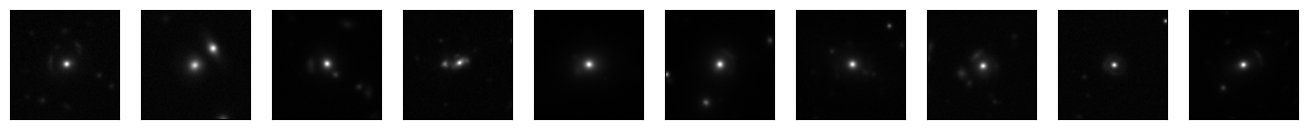

In [10]:
# For HR Data
%matplotlib inline
num_samples_to_visualize = 10
data_EDA(num_samples_to_visualize, data_HR)

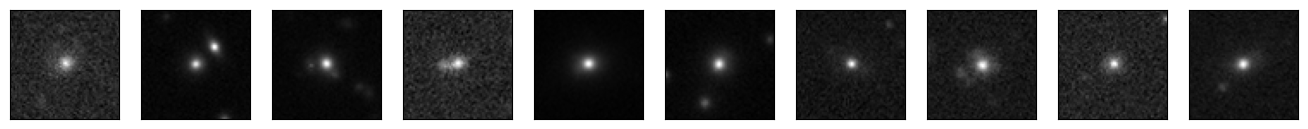

In [11]:
# For LR Data
%matplotlib inline
num_samples_to_visualize = 10
data_EDA(num_samples_to_visualize, data_LR)

### Part 3: Preprocessing for Model

In [12]:
# The Trained FSRCNN Model for Task 3A expects input as 75X75.
# The output is 150x150
# We will have to resize our LR and HR data accordingly.
# This will have some effect on our data. We are currently neglecting it.

# Resize Images
data_LR = resize_images_array(data_LR, (75,75))
data_HR = resize_images_array(data_HR, (150,150))

# Reshape images
data_LR = data_LR.reshape(-1, 75, 75, 1)
data_HR = data_HR.reshape(-1, 150, 150, 1)


In [13]:
print(f'data_HR shape: {data_HR.shape}')
print(f'data_LR shape: {data_LR.shape}')

data_HR shape: (300, 150, 150, 1)
data_LR shape: (300, 75, 75, 1)


### Part 4: Load Model

In [14]:
# Register the custom PSNR metric function
# The custom metrics have to be registerd first before use.
keras.utils.get_custom_objects()['psnr'] = psnr
keras.utils.get_custom_objects()['ssim'] = ssim

loaded_model = load_model('Trained Models\Task_3A_FSRCNN.keras')
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 56)        1456      
                                                                 
 p_re_lu (PReLU)             (None, 75, 75, 56)        315000    
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 12)        684       
                                                                 
 p_re_lu_1 (PReLU)           (None, 75, 75, 12)        67500     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 12)        1308      
                                                                 
 p_re_lu_2 (PReLU)           (None, 75, 75, 12)        67500     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 12)        

### Part 5: Train Model (Fine-Tuning)

In [15]:
# Fine Tune Model on Real Data
# Train_Test Split
# X = LR , Y = HR
LR_train, LR_test, HR_train, HR_test = train_test_split(data_LR , data_HR ,test_size=0.1)


In [16]:
print(f'LR_train: {LR_train.shape}')
print(f'HR_train: {HR_train.shape}')

LR_train: (270, 75, 75, 1)
HR_train: (270, 150, 150, 1)


In [17]:
history = loaded_model.fit(x= LR_train, y= HR_train, batch_size = 10,
                                  epochs = 15, shuffle = True, verbose = 2,
                                  validation_split = 0.1)

Epoch 1/15


25/25 - 13s - loss: 0.0020 - mean_squared_error: 0.0020 - psnr: 30.3735 - ssim: 0.6516 - val_loss: 8.5128e-04 - val_mean_squared_error: 8.5128e-04 - val_psnr: 32.7576 - val_ssim: 0.8267 - 13s/epoch - 517ms/step
Epoch 2/15
25/25 - 9s - loss: 0.0015 - mean_squared_error: 0.0015 - psnr: 32.4399 - ssim: 0.7923 - val_loss: 6.6500e-04 - val_mean_squared_error: 6.6500e-04 - val_psnr: 33.8535 - val_ssim: 0.7975 - 9s/epoch - 348ms/step
Epoch 3/15
25/25 - 7s - loss: 0.0016 - mean_squared_error: 0.0016 - psnr: 32.5261 - ssim: 0.8043 - val_loss: 6.2681e-04 - val_mean_squared_error: 6.2681e-04 - val_psnr: 34.0950 - val_ssim: 0.8130 - 7s/epoch - 297ms/step
Epoch 4/15
25/25 - 9s - loss: 0.0014 - mean_squared_error: 0.0014 - psnr: 33.5047 - ssim: 0.8082 - val_loss: 7.5937e-04 - val_mean_squared_error: 7.5937e-04 - val_psnr: 34.3400 - val_ssim: 0.8452 - 9s/epoch - 345ms/step
Epoch 5/15
25/25 - 9s - loss: 0.0014 - mean_squared_error: 0.0014 - psnr: 33.2049 - ssim: 0.8012 - val_loss: 6.8963e

Observe Training history

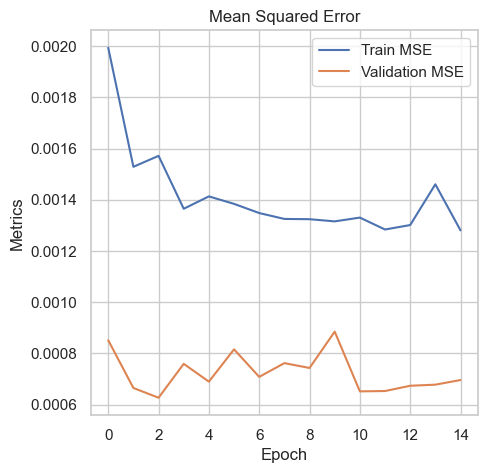

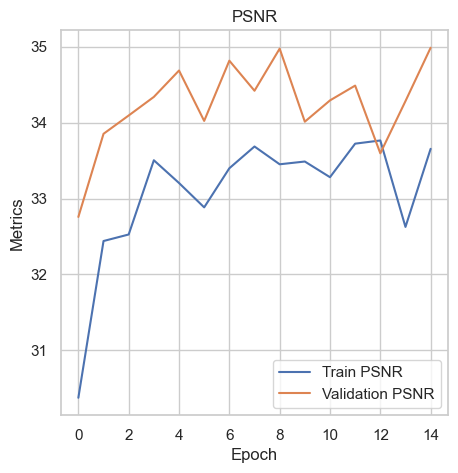

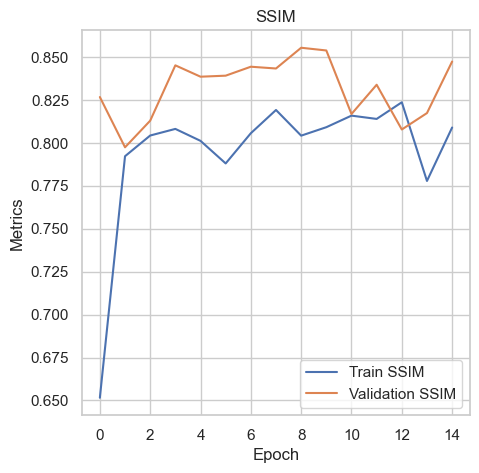

In [18]:
# Loss Curves for train and valid data for observing overfitting.
# Plotting the learning curves for train and validation metrics

# Set seaborn style
sns.set(style="whitegrid")

# Plotting MSE
plot_history(history,'mean_squared_error', 'val_mean_squared_error', 'Train MSE','Validation MSE', 'Mean Squared Error')

# Plotting PSNR
plot_history(history,'psnr', 'val_psnr', 'Train PSNR','Validation PSNR', 'PSNR')

# Plotting SSIM
plot_history(history,'ssim', 'val_ssim', 'Train SSIM','Validation SSIM', 'SSIM')

### Part 6: Evaluate Model

In [19]:
loaded_model.metrics_names

['loss', 'mean_squared_error', 'psnr', 'ssim']

In [20]:
train_loss, train_MSE, train_psnr, train_ssim = loaded_model.evaluate(LR_train, HR_train)
test_loss, test_MSE, test_psnr, test_ssim = loaded_model.evaluate(LR_test, HR_test)

print(f'Model Training MSE: {train_MSE:.2f}')
print(f'Model Training PSNR: {train_psnr:.2f}')
print(f'Model Training SSIM: {train_ssim:.2f}')

print(f'Model Testing MSE: {test_MSE:.2f}')
print(f'Model Testing PSNR: {test_psnr:.2f}')
print(f'Model Testing SSIM: {test_ssim:.2f}')

1/1 [==============================] - 0s 332ms/step - loss: 6.4279e-04 - mean_squared_error: 6.4279e-04 - psnr: 33.8373 - ssim: 0.8275
Model Training MSE: 0.00
Model Training PSNR: 34.06
Model Training SSIM: 0.83
Model Testing MSE: 0.00
Model Testing PSNR: 33.84
Model Testing SSIM: 0.83


### Part 7: Save Model

In [21]:
loaded_model.save('Trained Models\Task_3B_FSRCNN.keras')

**Note: Please pre-process test data as mentioned, before testing it using saved model**

Resize Images
loaded_LR_data = resize_images_array(loaded_LR_data, (75,75))
loaded_HR_data = resize_images_array(loaded_HR_data, (150,150))

reshape images
processed_LR_data = loaded_LR_data.reshape(-1, 75, 75, 1)
processed_HR_data = loaded_HR_data.reshape(-1, 150, 150, 1)

processed_HR_data = loaded_HR_data.reshape(-1, 150, 150, 1)
processed_LR_data = loaded_LR_data.reshape(-1, 75, 75, 1)

First Load HR data and LR data. loaded_HR_data is HR data. loaded_LR_data is LR Data. Pre-process to change shape as mentioned then use.

---

## Discussion

FSRCN model developed for image super resolution was fine-tuned on real data. The results are good. psnr values aboive 32 are obtained while ssim values above 0.8 are obtained. With increased inout images, the validation accuracy and overall model learning could be omproved. We can alos utilize other methods like k-fold cross validation for better model training. The data could be augmented to further increase dataset. We can also use other algorithms like few shot learning techniques to may be obtain better results. and Fine-tuning allowed to train models even when little data is available.

## Future Work

The results are very good. The data available is very small. A better version could be for diverse and different data sets increasing the robustness of the system. Techniques like k-fold cross validation, data augmentation and other super resolution algorithms could be explored to further enhance system capabilities.

## Conclusion

The model is a decent effort for solving the image super resolution problem. The results may be further expanded by exploring other models and comparison. 

---